In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import wfdb as wf

### Download the data

In [3]:
# List available databases
wf.get_dbs()

[['adfecgdb', 'Abdominal and Direct Fetal ECG Database'],
 ['aftdb', 'AF Termination Challenge Database'],
 ['ahadb', 'AHA Database [sample excluded record]'],
 ['aami-ec13', 'ANSI/AAMI EC13 Test Waveforms'],
 ['apnea-ecg', 'Apnea-ECG Database'],
 ['chfdb', 'BIDMC Congestive Heart Failure Database'],
 ['bidmc                   BIDMC PPG and Respiration Dataset'],
 ['bpssrat', 'Blood Pressure in Salt-Sensitive Dahl Rats'],
 ['capslpdb', 'CAP Sleep Database'],
 ['crisdb', 'CAST RR Interval Sub-Study Database'],
 ['cves', 'Cerebral Vasoregulation in Elderly with Stroke'],
 ['challenge/2009/test-set-a', 'Challenge 2009 Test Set A'],
 ['challenge/2009/test-set-b', 'Challenge 2009 Test Set B'],
 ['challenge/2010/set-a', 'Challenge 2010 Training Set A'],
 ['challenge/2010/set-b', 'Challenge 2010 Test Set B'],
 ['challenge/2010/set-c', 'Challenge 2010 Test Set C'],
 ['challenge/2011/set-a', 'Challenge 2011 Training Set A'],
 ['challenge/2011/set-b', 'Challenge 2011 Test Set B'],
 ['challenge/2

In [103]:
import os
wf.dl_database('mitdb', os.path.join(os.getcwd(), 'mitdb'))

### Explore meta

In [4]:
records = wf.get_record_list('mitdb')
#print(records)
print('There are', len(records), 'records in the MIT-BIH Arrhythmia Database.')

There are 48 records in the MIT-BIH Arrhythmia Database.


In [5]:
wf.show_ann_classes()

     extension                        description  human_reviewed
atr        atr          Reference ECG annotations            True
blh        blh         Human reviewed beat labels            True
blm        blm                Machine beat labels           False
alh        alh              Human reviewed alarms            True
alm        alm                     Machine alarms           False
qrsc      qrsc      Human reviewed qrs detections            True
qrs        qrs             Machine QRS detections           False
bph        bph  Human reviewed BP beat detections            True
bpm        bpm         Machine BP beat detections           False


Let's dig into the first record.

In [6]:
record = records[0]
signals, fields = wf.rdsamp('mitdb/' + record)
annotations = wf.rdann('mitdb/' + record, 'atr',    # only .atr comes with this database
                       return_label_elements = ['symbol', 'description'], summarize_labels = True)  

In [7]:
#print(signals.shape)
#print(signals.min(),signals.max())
#print(fields.keys())

print('There are', fields['n_sig'], 'ECG channels')
print('The names of the channels are', fields['sig_name'])
print('The units of the channels are', fields['units'])
print('The length of each signal is', fields['sig_len'], 'samples')
print('The sampling frequency of the signal is', fields['fs'], 'Hz')
print('Comments written in the header:', fields['comments'])

There are 2 ECG channels
The names of the channels are ['MLII', 'V5']
The units of the channels are ['mV', 'mV']
The length of each signal is 650000 samples
The sampling frequency of the signal is 360 Hz
Comments written in the header: ['69 M 1085 1629 x1', 'Aldomet, Inderal']


(The channels MLII and V5 are two different electrode configurations and are considered the best two for getting a good signal.

Source: https://www.physionet.org/faq.shtml#signal-names)

### Explore annotations more
#### See https://www.physionet.org/physiobank/annotations.shtml

In [8]:
#help(wf.Annotation)
wf.show_ann_labels()

    label_store symbol                                    description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13     

In [9]:
annotations.contained_labels

,label_store,symbol,description
8,8,A,Atrial premature contraction
1,1,N,Normal beat
28,28,+,Rhythm change
5,5,V,Premature ventricular contraction


In [10]:
beats = np.in1d(annotations.symbol, 
                ['N', 'L', 'R', 'B', 'A', 'a', 'J', 'S', 'V', 'r', 'F', 'e', 'j', 'n', 'E', '/', 'f', 'Q', '?'])
print(beats.sum() / len(annotations.symbol) * 100. , '% of annotations for record' , record , 'are beat annotations')

99.95602462620933 % of annotations for record 100 are beat annotations


### Try some basic plotting

In [11]:
rcParams['mathtext.default']='regular'
plt.rc('font', family='monospace', )
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

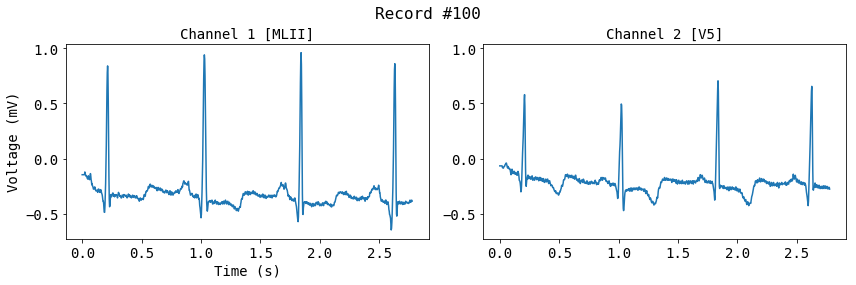

In [12]:
nsamples = np.arange(1000)
#nsamples = np.arange(fields['sig_len'])

fig = plt.figure(figsize=(12,4))

ax1 = plt.subplot(121)
plt.plot(nsamples / fields['fs'], signals[nsamples,0])
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Voltage (mV)', fontsize=14)
plt.title('Channel 1 [' + fields['sig_name'][0] + ']', fontsize=14)

ax2 = plt.subplot(122, sharex=ax1, sharey=ax1)
plt.plot(nsamples / fields['fs'], signals[nsamples,1])
plt.title('Channel 2 [' + fields['sig_name'][1] + ']', fontsize=14)
#plt.setp(ax2.get_yticklabels(), visible=False)

plt.suptitle('Record #' + record, fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

### Let's get a bit fancier and try zooming in on an exciting annotation

In [13]:
# Let's select the first 'A' ('atrial premature contraction') annotation and zoom in
ann_ind = np.in1d(annotations.symbol, ['A'])
samp_ind = annotations.sample[ann_ind]
chan = annotations.chan[ann_ind][0]
annx, anny = samp_ind[0] / fields['fs'], signals[samp_ind[0],chan]
anntext = np.array(annotations.description)[ann_ind][0]

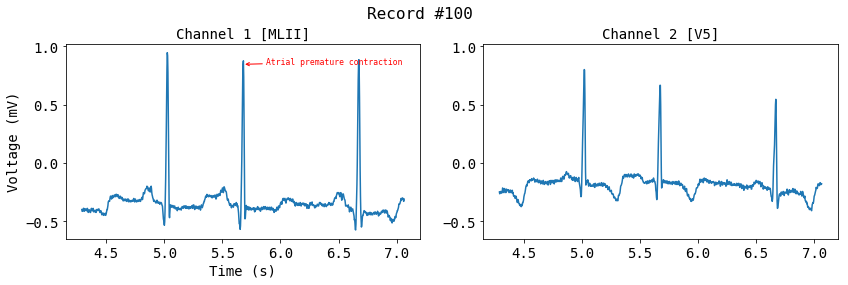

In [15]:
nsamples = np.arange(samp_ind[0] - 500, samp_ind[0] + 500)

fig = plt.figure(figsize=(12,4))

ax1 = plt.subplot(121)
plt.plot(nsamples / fields['fs'], signals[nsamples,0])
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Voltage (mV)', fontsize=14)
plt.title('Channel 1 [' + fields['sig_name'][0] + ']', fontsize=14)

ax2 = plt.subplot(122, sharex=ax1, sharey=ax1)
plt.plot(nsamples / fields['fs'], signals[nsamples,1])
plt.title('Channel 2 [' + fields['sig_name'][1] + ']', fontsize=14)
#plt.setp(ax2.get_yticklabels(), visible=False)

if chan == 0:
    ax1.annotate(anntext, xy=(annx, anny), xytext=(annx + 0.2, anny), fontsize=8, color='red',
                arrowprops=dict(color='red', arrowstyle="->"))
else:
    ax2.annotate(anntext, xy=(annx, anny), xytext=(annx + 0.2, anny), fontsize=8, color='red',
                arrowprops=dict(color='red', arrowstyle="->"))

plt.suptitle('Record #' + record, fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()